In [3]:
# All the imports required for this implementation
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

from torch.utils.data import TensorDataset, ConcatDataset, random_split, DataLoader, Dataset

from torchinfo import summary # Allows us to summarise the params and layers

import numpy as np
import matplotlib.pyplot as plt

In [4]:
# We can make use of a GPU if you have one on your computer. This works for Nvidia and M series GPU's
if torch.backends.mps.is_available():
    device = torch.device("mps")
    # These 2 lines assign some data on the memory of the device and output it. The output confirms
    # if we have set the intended device
    x = torch.ones(1, device=device)
    print (x)
elif torch.backends.cuda.is_built():
    device = torch.device("cuda")
    x = torch.ones(1, device=device)
    print (x)
else:
    device = ("cpu")
    x = torch.ones(1, device=device)
    print (x)

tensor([1.], device='cuda:0')


Due to storage constraints and to keep this notebook accessible I will use a 256x256 CelebA-HQ dataset not the original 1024x1024. In the paper it is stated that train this network on smaller than 1024x1024 we can just chop off the layers until we get to 256x256

Dataset can be found at: https://www.kaggle.com/datasets/badasstechie/celebahq-resized-256x256

First let's implement the D and G given by:

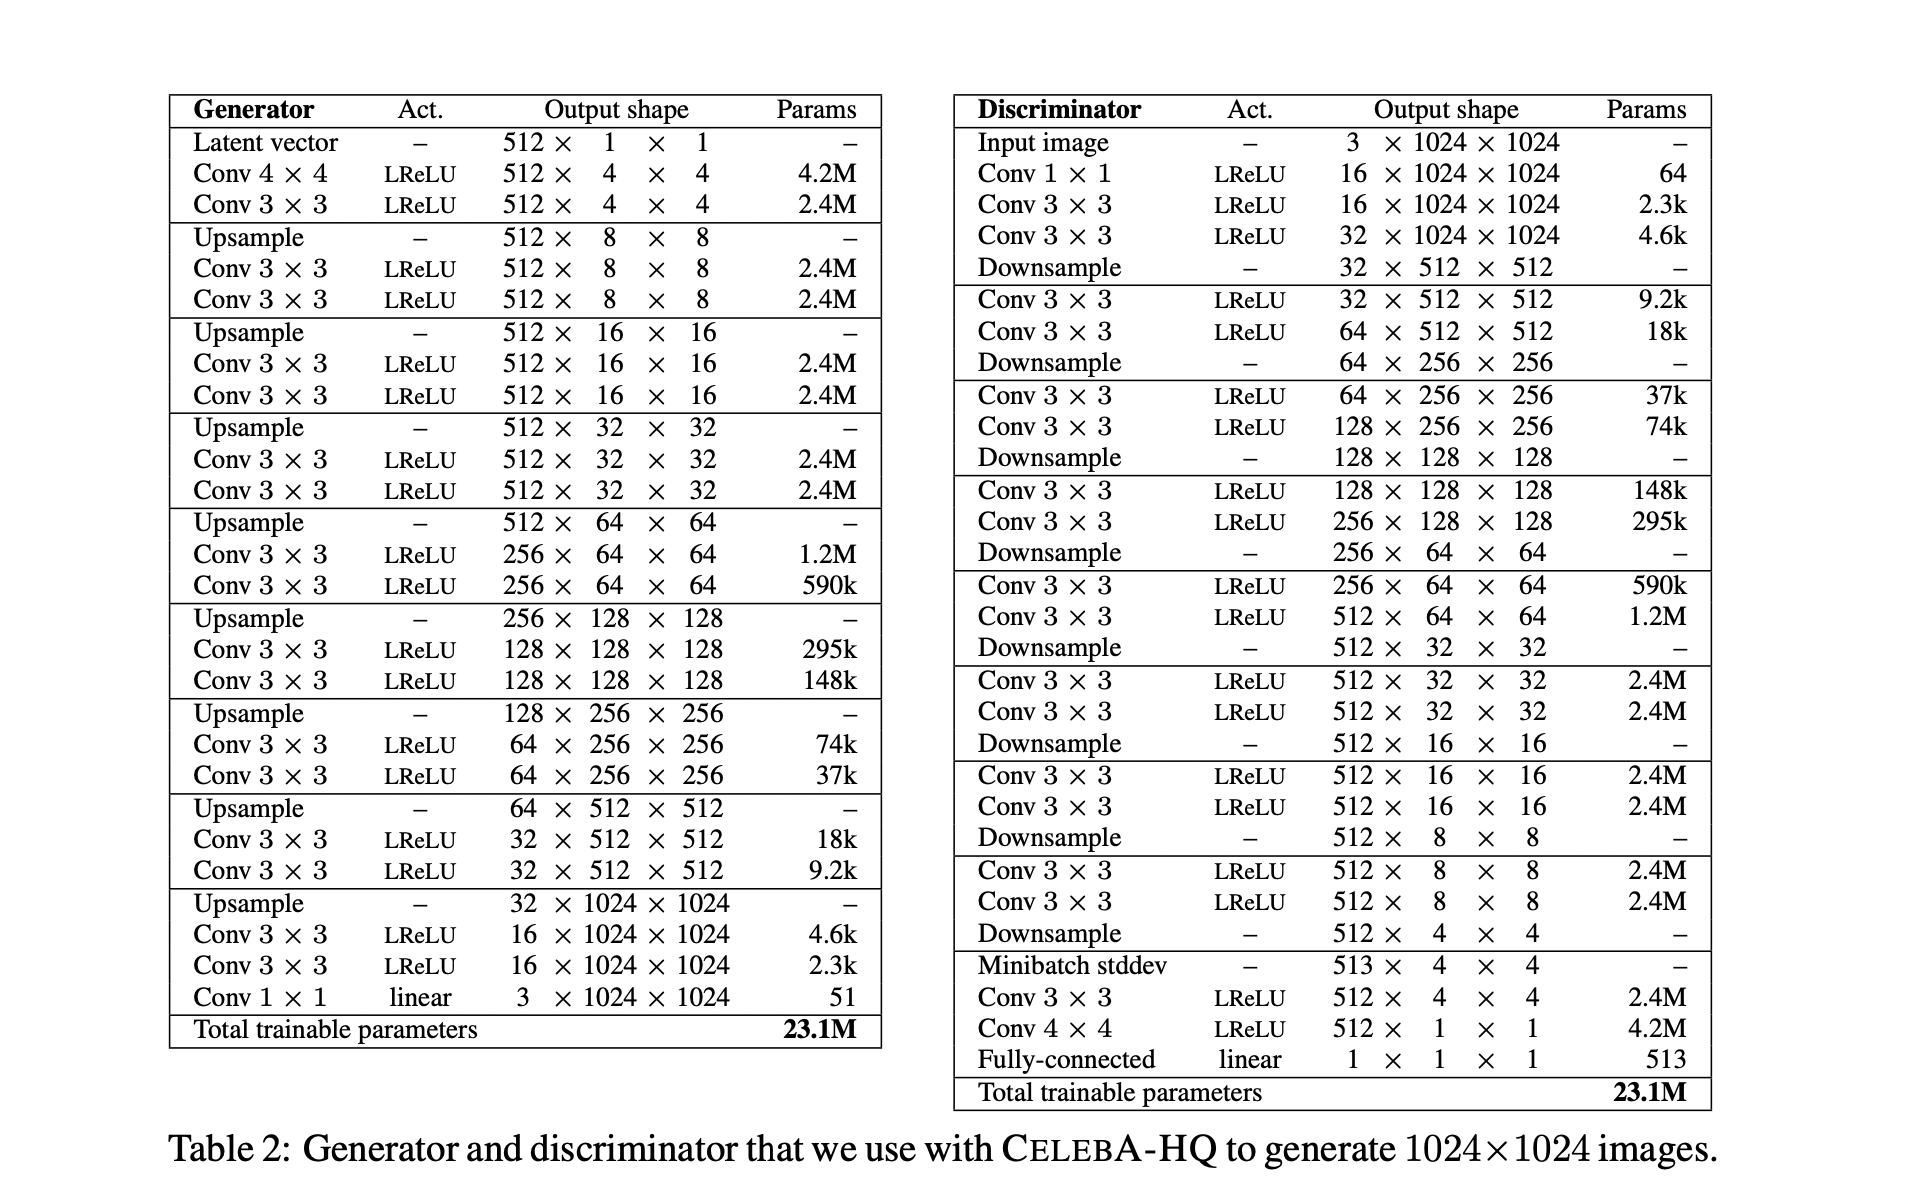

We will implement these without the other aspects they discuss in the paper and see what results we get (i.e. without the smooth intro layers with the resnet type structure, without the toRGB and fromRGB, without minibatch stdev) and let's see what we get.

In [3]:
# Load the data and display some images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# To load the data you must move the images to a folder within the dir they are in
dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)

In [5]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

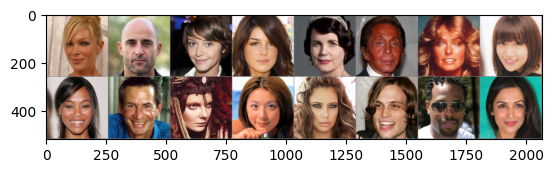

(None, tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [5]:
# get some random training images
dataiter = iter(dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images)), labels

In [6]:
# Now let's define the G model
# In this model I begin downsamp
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input is a tensor (batch_size, 512, 1, 1)
        # We first need to upscale it to 4x4
        self.conv1 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            # This was counter intuitive. Will need explaining but it acts as a FC layer
            # where we transform 1x1 input to 4x4 output
            kernel_size=(4,4),
            padding=(3,3),
        )
        self.LRelu1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1),  # Need 1 padding to preserve dim, explain why and compare with/without the padding
        )
        self.LRelu2 = nn.LeakyReLU(0.2)
        
        # Upsample to 8x8
        '''
        I dont use ConvTranspose as the upsample doesn't have params whereas this does
        self.up1 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(2,2),
            stride=(2,2),
        )'''
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')  # In the paper it is stated they use NN interpolation
        self.conv3 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1),
        )
        self.LRelu3 = nn.LeakyReLU(0.2)
        self.conv4 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1), 
        )
        self.LRelu4 = nn.LeakyReLU(0.2)
        
        # Upsample to 16x16
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')  # In the paper it is stated they use NN interpolation
        self.conv5 = nn.Conv2d(
            in_channels=512,
            out_channels=256,
            kernel_size=(3,3),
            padding=(1,1),
        )
        self.LRelu5 = nn.LeakyReLU(0.2)
        self.conv6 = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=(3,3),
            padding=(1,1), 
        )
        self.LRelu6 = nn.LeakyReLU(0.2)
        
        # Upsample to 32x32
        self.up3 = nn.Upsample(scale_factor=2, mode='nearest')  # In the paper it is stated they use NN interpolation
        self.conv7 = nn.Conv2d(
            in_channels=256,
            out_channels=128,
            kernel_size=(3,3),
            padding=(1,1),
        )
        self.LRelu7 = nn.LeakyReLU(0.2)
        self.conv8 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=(3,3),
            padding=(1,1), 
        )
        self.LRelu8 = nn.LeakyReLU(0.2)
        
        # Upsample to 64x64
        self.up4 = nn.Upsample(scale_factor=2, mode='nearest')  # In the paper it is stated they use NN interpolation
        self.conv9 = nn.Conv2d(
            in_channels=128,
            out_channels=64,
            kernel_size=(3,3),
            padding=(1,1),
        )
        self.LRelu9 = nn.LeakyReLU(0.2)
        self.conv10 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3,3),
            padding=(1,1), 
        )
        self.LRelu10 = nn.LeakyReLU(0.2)
        
        # Upsample to 128x128
        self.up5 = nn.Upsample(scale_factor=2, mode='nearest')  # In the paper it is stated they use NN interpolation
        self.conv11 = nn.Conv2d(
            in_channels=64,
            out_channels=32,
            kernel_size=(3,3),
            padding=(1,1),
        )
        self.LRelu11 = nn.LeakyReLU(0.2)
        self.conv12 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3,3),
            padding=(1,1), 
        )
        self.LRelu12 = nn.LeakyReLU(0.2)
        
        # Upsample to 256x256
        self.up6 = nn.Upsample(scale_factor=2, mode='nearest')  # In the paper it is stated they use NN interpolation
        self.conv13 = nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3,3),
            padding=(1,1),
        )
        self.LRelu13 = nn.LeakyReLU(0.2)
        self.conv14 = nn.Conv2d(
            in_channels=16,
            out_channels=16,
            kernel_size=(3,3),
            padding=(1,1), 
        )
        self.LRelu14 = nn.LeakyReLU(0.2)
        
        # The last conv corresponds to the toRGB func
        self.toRGB = nn.Conv2d(
            in_channels=16,
            out_channels=3,
            kernel_size=(1,1),
        )
        
        
    def forward(self, x):
        # Block 1
        #print(f'input shape: {x.shape}')
        x = self.conv1(x)
        x = self.LRelu1(x)
        #print(f'conv1 out: {x.shape}')
        x = self.conv2(x)
        x = self.LRelu2(x)
        #print(f'conv2 out: {x.shape}')
        
        # Block 2 - Upsample to 8x8
        # Lets try an ConvTranspose2d and an KNN upsamle
        # ConvTranspose2d introduces parameters which leads me to believe its the wrong thing to use
        x = self.up1(x)
        #print(f'up1 out: {x.shape}')
        x = self.conv3(x)
        x = self.LRelu3(x)
        #print(f'conv3 out: {x.shape}')
        x = self.conv4(x)
        x = self.LRelu4(x)
        #print(f'conv4 out: {x.shape}')
        
        # Block 3 - Upsample to 16x16
        x = self.up2(x)
        #print(f'up2 out: {x.shape}')
        x = self.conv5(x)
        x = self.LRelu5(x)
        #print(f'conv5 out: {x.shape}')
        x = self.conv6(x)
        x = self.LRelu6(x)
        #print(f'conv6 out: {x.shape}')
        
        # Block 4 - Upsample to 32x32
        x = self.up3(x)
        #print(f'up3 out: {x.shape}')
        x = self.conv7(x)
        x = self.LRelu7(x)
        #print(f'conv7 out: {x.shape}')
        x = self.conv8(x)
        x = self.LRelu8(x)
        #print(f'conv8 out: {x.shape}')
        
        # Block 5 - Upsample to 64x64
        x = self.up4(x)
        #print(f'up4 out: {x.shape}')
        x = self.conv9(x)
        x = self.LRelu9(x)
        #print(f'conv9 out: {x.shape}')
        x = self.conv10(x)
        x = self.LRelu10(x)
        #print(f'conv10 out: {x.shape}')
        
        # Block 6 - Upsample to 128x128
        x = self.up5(x)
        #print(f'up5 out: {x.shape}')
        x = self.conv11(x)
        x = self.LRelu11(x)
        #print(f'conv11 out: {x.shape}')
        x = self.conv12(x)
        x = self.LRelu12(x)
        #print(f'conv12 out: {x.shape}')
        
        # Block 7 - Upsample to 256x256
        x = self.up6(x)
        #print(f'up6 out: {x.shape}')
        x = self.conv13(x)
        x = self.LRelu13(x)
        #print(f'conv13 out: {x.shape}')
        x = self.conv14(x)
        x = self.LRelu14(x)
        #print(f'conv14 out: {x.shape}')
        
        # toRGB
        x = self.toRGB(x)
        #print(f'conv15 out: {x.shape}')
        
        return x

generator = Generator()

In [257]:
test_g_in = np.random.normal(0, 1, (512,1,1))
# The input to our network has to be a tensor datatype, in this case it just has one value
test_g_in = torch.tensor(test_g_in, dtype=torch.float32)
test_g_in = torch.unsqueeze(test_g_in, 0) # Add a batch_size dimension

test_g_out = generator(test_g_in)
#print(test_g_out)

In [8]:
summary(generator, input_size=(1,512,1,1))

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 256, 256]          --
├─Conv2d: 1-1                            [1, 512, 4, 4]            4,194,816
├─LeakyReLU: 1-2                         [1, 512, 4, 4]            --
├─Conv2d: 1-3                            [1, 512, 4, 4]            2,359,808
├─LeakyReLU: 1-4                         [1, 512, 4, 4]            --
├─Upsample: 1-5                          [1, 512, 8, 8]            --
├─Conv2d: 1-6                            [1, 512, 8, 8]            2,359,808
├─LeakyReLU: 1-7                         [1, 512, 8, 8]            --
├─Conv2d: 1-8                            [1, 512, 8, 8]            2,359,808
├─LeakyReLU: 1-9                         [1, 512, 8, 8]            --
├─Upsample: 1-10                         [1, 512, 16, 16]          --
├─Conv2d: 1-11                           [1, 256, 16, 16]          1,179,904
├─LeakyReLU: 1-12                        [1, 256, 

In [9]:
# Now let's define the D model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
                    
        # First conv corresponds to fromRGB
        self.fromRGB = nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=(1,1),
        )
        self.LRelu1 = nn.LeakyReLU(0.2)
        
        self.conv2 = nn.Conv2d(
            in_channels=16,
            out_channels=16,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu2 = nn.LeakyReLU(0.2)
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu3 = nn.LeakyReLU(0.2)
        # Downsample to 128x128, use AvgPool
        self.down1 = nn.AvgPool2d(
            kernel_size=(2,2),
        )
        
        self.conv4 = nn.Conv2d(
            in_channels=32,
            out_channels=32,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu4 = nn.LeakyReLU(0.2)
        self.conv5 = nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu5 = nn.LeakyReLU(0.2)
        # Downsample to 64x64, use AvgPool
        self.down2 = nn.AvgPool2d(
            kernel_size=(2,2),
        )
        
        self.conv6 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu6 = nn.LeakyReLU(0.2)
        self.conv7 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu7 = nn.LeakyReLU(0.2)
        # Downsample to 32x32, use AvgPool
        self.down3 = nn.AvgPool2d(
            kernel_size=(2,2),
        )
        
        self.conv8 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu8 = nn.LeakyReLU(0.2)
        self.conv9 = nn.Conv2d(
            in_channels=128,
            out_channels=256,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu9 = nn.LeakyReLU(0.2)
        # Downsample to 16x16, use AvgPool
        self.down4 = nn.AvgPool2d(
            kernel_size=(2,2),
        )
        
        self.conv10 = nn.Conv2d(
            in_channels=256,
            out_channels=256,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu10 = nn.LeakyReLU(0.2)
        self.conv11 = nn.Conv2d(
            in_channels=256,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu11 = nn.LeakyReLU(0.2)
        # Downsample to 8x8, use AvgPool
        self.down5 = nn.AvgPool2d(
            kernel_size=(2,2),
        )
        
        self.conv12 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu12 = nn.LeakyReLU(0.2)
        self.conv13 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu13 = nn.LeakyReLU(0.2)
        # Downsample to 4x4, use AvgPool
        self.down6 = nn.AvgPool2d(
            kernel_size=(2,2),
        )
        
        self.conv14 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(3,3),
            padding=(1,1)
        )
        self.LRelu14 = nn.LeakyReLU(0.2)
        self.conv15 = nn.Conv2d(
            in_channels=512,
            out_channels=512,
            kernel_size=(4,4),
            #padding=(0,0)
        )
        self.LRelu15 = nn.LeakyReLU(0.2)
        
        # FC output layer
        self.FC1 = nn.Linear(512,1)
        
    
    def forward(self, x, layer_nums=7):
        # Block 1
        # This is the fromRGB transform
        print(x.shape)
        x = self.fromRGB(x)
        x = self.LRelu1(x)
        
        # Block 1
        if layer_nums >= 1:
            print("BLOCK 1 ACTIVE")
            x = self.conv2(x)
            x = self.LRelu2(x)
            x = self.conv3(x)
            x = self.LRelu3(x)
            x = self.down1(x)
        
        # Block 2
        if layer_nums >= 2:
            print("BLOCK 2 ACTIVE")
            x = self.conv4(x)
            x = self.LRelu4(x)
            x = self.conv5(x)
            x = self.LRelu5(x)
            x = self.down2(x)
        
        # Block 3
        if layer_nums >= 3:
            print("BLOCK 3 ACTIVE")
            x = self.conv6(x)
            x = self.LRelu6(x)
            x = self.conv7(x)
            x = self.LRelu7(x)
            x = self.down3(x)
        
        # Block 4
        if layer_nums >= 4:
            print("BLOCK 4 ACTIVE")
            x = self.conv8(x)
            x = self.LRelu8(x)
            x = self.conv9(x)
            x = self.LRelu9(x)
            x = self.down4(x)

        # Block 5
        if layer_nums >= 5:
            print("BLOCK 5 ACTIVE")
            x = self.conv10(x)
            x = self.LRelu10(x)
            x = self.conv11(x)
            x = self.LRelu11(x)
            x = self.down5(x)
        
        # Block 6
        if layer_nums >= 6:
            print("BLOCK 6 ACTIVE")
            x = self.conv12(x)
            x = self.LRelu12(x)
            x = self.conv13(x)
            x = self.LRelu13(x)
            x = self.down6(x)
        
        # Block 7
        if layer_nums >= 7:
            print("BLOCK 7 ACTIVE")
            x = self.conv14(x)
            x = self.LRelu14(x)
            x = self.conv15(x)
            x = self.LRelu15(x)
        
        # Last FC layer
        print(x.shape)
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        print(x.shape)
        x = self.FC1(x)
        
        return x

discriminator = Discriminator()

In [10]:
summary(discriminator, input_size=(1, 3, 256, 256))

torch.Size([1, 3, 256, 256])
BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 3 ACTIVE
BLOCK 4 ACTIVE
BLOCK 5 ACTIVE
BLOCK 6 ACTIVE
BLOCK 7 ACTIVE
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Conv2d: 1-1                            [1, 16, 256, 256]         64
├─LeakyReLU: 1-2                         [1, 16, 256, 256]         --
├─Conv2d: 1-3                            [1, 16, 256, 256]         2,320
├─LeakyReLU: 1-4                         [1, 16, 256, 256]         --
├─Conv2d: 1-5                            [1, 32, 256, 256]         4,640
├─LeakyReLU: 1-6                         [1, 32, 256, 256]         --
├─AvgPool2d: 1-7                         [1, 32, 128, 128]         --
├─Conv2d: 1-8                            [1, 32, 128, 128]         9,248
├─LeakyReLU: 1-9                         [1, 32, 128, 128]         --
├─Conv2d: 1-10                           [1, 64, 128, 128]         18,496
├─LeakyReLU: 1-11                        [1, 64, 128, 128]         --
├─AvgPool2d: 1-12                        [1, 64, 64, 64]           --
├─

In [11]:
# Now I need to figure out the training routine
# Each block see's 600k images before beginning fading in new block. This corresponds to 20 epochs per block
# 600k / 30k = 20


# So the training dynamic is as follows:
    - We train the first block of G and D for 20 epochs
    - Then begin fading in the next block, we need to decide on some linear growth for the alpha parameter. 
    - When training the new block the output from the old block is included in the output
    - Alpha grows linearly from 0 -> 1. So the output from old block gets less and less weight
    - Network is trained for 20 epochs where the new block is faded in and then 20 more without the residual connection
    
Let's make some code which can replicate this without the actual NN training

In [12]:
'''
In a traditional training loop we have:
    - Loop 1 -> Training epochs
    - Loop 2 -> Loop for pushing each batch through the network

To realise the architecture outlined above we need: 
    - Loop 0 -> Load in the new block, this runs 7 times?
        - Loop 1 -> The training epochs
            - Loop 2 -> The batches loop, the first loop introduces the new layer and we fade it in
            - Loop 3 -> Another batches loop, this time we train the new layers along with the old
                        without residual connection
'''

'\nIn a traditional training loop we have:\n    - Loop 1 -> Training epochs\n    - Loop 2 -> Loop for pushing each batch through the network\n\nTo realise the architecture outlined above we need: \n    - Loop 0 -> Load in the new block, this runs 7 times?\n        - Loop 1 -> The training epochs\n            - Loop 2 -> The batches loop, the first loop introduces the new layer and we fade it in\n            - Loop 3 -> Another batches loop, this time we train the new layers along with the old\n                        without residual connection\n'

In [13]:
# This is my demo code, it will implement the 4 loops needed and output something illustrative
# Let's repr the models with 2 lists
g = [1,2,3,4,5,6,7]
d = [1,2,3,4,5,6,7]
# toRGB will be the string "toRGB" similar for fromRGB
to = 'toRGB'
fr = 'fromRGB'

alpha = 0

# We need to define a linear growth for alpha, let's use alpha += 1/20 so as to 

for i in range(7):
    for epoch in range(20):
        ...
    
    for epoch in range(20):
        ...

In [14]:
# Let's run the forward method using the first 3 layers
d_input = torch.rand(1, 3, 256, 256)

d_out = discriminator(d_input, 7)

torch.Size([1, 3, 256, 256])
BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 3 ACTIVE
BLOCK 4 ACTIVE
BLOCK 5 ACTIVE
BLOCK 6 ACTIVE
BLOCK 7 ACTIVE
torch.Size([1, 512, 1, 1])
torch.Size([1, 512])


Let's change tack, I want to change how the model's are created. There is a lot of repetition in the code, I want to try and generate the models using PyTorch magic instead of what I've done so far?

In [12]:
# Let's define a function which can generate the conv block
def d_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None):
    if kernel_size2 is not None:
        block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels, out_channels, kernel_size2, padding=(1,1)),
            nn.LeakyReLU(0.2),
            # Downsample
            nn.AvgPool2d(kernel_size=(2,2)),
        )
    else:
        block = nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            # Downsample
            nn.AvgPool2d(kernel_size=(2,2)),
        )
    
    return block

def from_to_RGB(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(1,1)),
        nn.LeakyReLU(0.2),
    )
    return block

# Create a function to create the output layer?
def d_output_layer(input_dim):
    layer = nn.Linear(input_dim, 1)
    return layer

In [186]:
# New D model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        # First conv corresponds to fromRGB
        self.fromRGB = from_to_RGB(in_channels=3, out_channels=16)
        
        # Let's replace the middle blocks (1-6) with the function call
        #self.block1 = conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3))
        #self.block2 = conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3))
        #self.block3 = conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3))
        #self.block4 = conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3))
        #self.block5 = conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3))
        #self.block6 = conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3))
        #self.block6 = conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3))
        #self.block7 = conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4))
        
        self.block1 = None
        self.block2 = None
        self.block3 = None
        self.block4 = None
        self.block5 = None
        self.block6 = None
        self.block7 = None
        # If none we add the model in the forward pass? 
        # issue remains of last layer and the FC layer
        
        # Now let's try and do this dynamically using a list?
        
        
        # FC output layer
        # I will hardcode the different FC layers
        self.FC1 = None
        
    # We can use this method to reset the FC layer after we complete training for each block
    def reset_output_layer(self):
        self.FC1 = None
        
    # def activate_layer(self, layer)  Perhaps this is a better way to init the layers?
    
    def forward(self, x, layer_nums=7):
        # Block 1
        # This is the fromRGB transform
        #print(x.shape)
        x = self.fromRGB(x)
        
        # Block 1
        if layer_nums >= 1:
            print("BLOCK 1 ACTIVE")
            if self.block1 is None:
                self.block1 = d_conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3))
            x = self.block1(x)    
        # Block 2
        if layer_nums >= 2:
            print("BLOCK 2 ACTIVE")
            if self.block2 is None:
                self.block2 = d_conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3))
            x = self.block2(x)
        # Block 3
        if layer_nums >= 3:
            print("BLOCK 3 ACTIVE")
            if self.block3 is None:
                self.block3 = d_conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3))
            x = self.block3(x)        
        # Block 4
        if layer_nums >= 4:
            print("BLOCK 4 ACTIVE")
            if self.block4 is None:
                self.block4 = d_conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3))
            x = self.block4(x)
        # Block 5
        if layer_nums >= 5:
            print("BLOCK 5 ACTIVE")
            if self.block5 is None:
                self.block5 = d_conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3))
            x = self.block5(x)        
        # Block 6
        if layer_nums >= 6:
            print("BLOCK 6 ACTIVE")
            if self.block6 is None:
                self.block6 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3))
            x = self.block6(x)        
        # Block 7
        if layer_nums >= 7:
            print("BLOCK 7 ACTIVE")
            if self.block7 is None:
                self.block7 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4))
            x = self.block7(x)
        
        # Last FC layer, this may need to be hardcoded? 
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1))
        #print(x.shape)
        x = self.FC1(x)
        
        return x

discriminator = Discriminator()

In [187]:
summary(discriminator, input_size=(1, 3, 256, 256))

BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 3 ACTIVE
BLOCK 4 ACTIVE
BLOCK 5 ACTIVE
BLOCK 6 ACTIVE
BLOCK 7 ACTIVE


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    --
├─Sequential: 1-1                        [1, 16, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         64
│    └─LeakyReLU: 2-2                    [1, 16, 256, 256]         --
Total params: 64
Trainable params: 64
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 4.19
Input size (MB): 0.79
Forward/backward pass size (MB): 8.39
Params size (MB): 0.00
Estimated Total Size (MB): 9.18

In [188]:
d_input = torch.rand(1, 3, 256, 256)
d_out = discriminator(d_input, 1)
d_out

BLOCK 1 ACTIVE


tensor([[0.0349]], grad_fn=<AddmmBackward0>)

In [24]:
# Save weights of the first conv in the first block
before_weight = discriminator.block1[0].weight
# Call forward pass and init second layer
d_out_2 = discriminator(torch.rand(1,3,256,256), 3)
after_weight = discriminator.block1[0].weight

print((before_weight == after_weight))  # We see that the weights remain the same so this method should work!

BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 3 ACTIVE
tensor([[[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         ...,

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]]],


        [[[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

         ...,

         [[True, True, True],
          [True, True, True],
          [True, True, True]],

   

In [25]:
# Let's run a mock training loop and let's see what happens
'''
To realise the architecture outlined above we need: 
    - Loop 0 -> Load in the new block, this runs 7 times?
        - Loop 1 -> The training epochs
            - Loop 2 -> The batches loop, the first loop introduces the new layer and we fade it in
            - Loop 3 -> Another batches loop, this time we train the new layers along with the old
                        without residual connection
'''
# Remember each block is trained for 20 epochs and we have 7 blocks
layer = 1
for epoch in range(20*7):
    print(f'Epoch: {epoch}')
    
    if epoch % 20 == 0:
        d_out = discriminator(d_input, layer)
        layer += 1
        print(discriminator)
    

Epoch: 0
BLOCK 1 ACTIVE
Discriminator(
  (fromRGB): Sequential(
    (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (FC1): Linear(in_features=524288, out_features=1, bias=True)
  (block1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slo

BLOCK 5 ACTIVE
BLOCK 6 ACTIVE
BLOCK 7 ACTIVE
Discriminator(
  (fromRGB): Sequential(
    (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (FC1): Linear(in_features=512, out_features=1, bias=True)
  (block1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.2)
    (4): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
  )
  (block3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Leak

In [26]:
block = nn.Sequential()
block.append(nn.ModuleList([nn.Upsample(scale_factor=2, mode='nearest'), nn.ReLU()]))
block

Sequential(
  (0): ModuleList(
    (0): Upsample(scale_factor=2.0, mode='nearest')
    (1): ReLU()
  )
)

In [27]:
# The d_conv_block is slightly different from the g_conv_block so we need to account for this
def g_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None, upsample=False):
    if upsample:
        block = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
        )
    else:
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            nn.LeakyReLU(0.2),
        )
    
    return block

def from_to_RGB(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(1,1)),
        nn.LeakyReLU(0.2),
    )
    return block


In [65]:
# Now let's define the G model
# In this model I begin downsamp
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Input is a tensor (batch_size, 512, 1, 1)
        
        self.block1 = None
        self.block2 = None
        self.block3 = None
        self.block4 = None
        self.block5 = None
        self.block6 = None
        self.block7 = None
        
        self.to_RGB = None
        
        
    def forward(self, x, layer_nums=7):
        
        # Block 1 - Upsample to 4x4 using 4x4 conv
        if layer_nums >= 1:
            print("BLOCK 1 ACTIVE")
            if self.block1 is None:
                self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3))
            x = self.block1(x)
        
        # Block 2 - Upsample to 8x8
        if layer_nums >= 2:
            print("BLOCK 2 ACTIVE")
            if self.block2 is None:
                self.block2 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), upsample=True)
            x = self.block2(x)
        
        # Block 3 - Upsample to 16x16
        if layer_nums >= 3:
            print("BLOCK 3 ACTIVE")
            if self.block3 is None:
                self.block3 = g_conv_block(in_channels=512, out_channels=256, kernel_size1=(3,3), upsample=True)
            x = self.block3(x)
        
        # Block 4 - Upsample to 32x32
        if layer_nums >= 4:
            print("BLOCK 4 ACTIVE")
            if self.block4 is None:
                self.block4 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), upsample=True)
            x = self.block4(x)
        
        # Block 5 - Upsample to 64x64
        if layer_nums >= 5:
            print("BLOCK 5 ACTIVE")
            if self.block5 is None:
                self.block5 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), upsample=True)
            x = self.block5(x)
        
        # Block 6 - Upsample to 128x128
        if layer_nums >= 6:
            print("BLOCK 6 ACTIVE")
            if self.block6 is None:
                self.block6 = g_conv_block(in_channels=64, out_channels=32, kernel_size1=(3,3), upsample=True)
            x = self.block6(x)
        
        # Block 7 - Upsample to 256x256
        if layer_nums >= 7:
            print("BLOCK 7 ACTIVE")
            if self.block7 is None:
                self.block7 = g_conv_block(in_channels=32, out_channels=16, kernel_size1=(3,3), upsample=True)
            x = self.block7(x)
            
        print(x.shape)
        
        # toRGB
        if self.to_RGB is None:
            self.to_RGB = from_to_RGB(in_channels=x.size(1), out_channels=3)
        x = self.to_RGB(x)
        
        return x

new_generator = Generator()

In [66]:
print(generator)  # Print old G for comparison here
print()
new_generator(test_g_in)
print(new_generator)

Generator(
  (conv1): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
  (LRelu1): LeakyReLU(negative_slope=0.2)
  (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LRelu2): LeakyReLU(negative_slope=0.2)
  (up1): Upsample(scale_factor=2.0, mode='nearest')
  (conv3): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LRelu3): LeakyReLU(negative_slope=0.2)
  (conv4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LRelu4): LeakyReLU(negative_slope=0.2)
  (up2): Upsample(scale_factor=2.0, mode='nearest')
  (conv5): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LRelu5): LeakyReLU(negative_slope=0.2)
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LRelu6): LeakyReLU(negative_slope=0.2)
  (up3): Upsample(scale_factor=2.0, mode='nearest')
  (conv7): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (LRelu7): LeakyReLU(negati

In [77]:
summary(new_generator, input_size=(1,512,1,1))

BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 3 ACTIVE
BLOCK 4 ACTIVE
BLOCK 5 ACTIVE
BLOCK 6 ACTIVE
BLOCK 7 ACTIVE
torch.Size([1, 16, 256, 256])


Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [1, 3, 256, 256]          --
├─Sequential: 1-1                        [1, 512, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 512, 4, 4]            4,194,816
│    └─LeakyReLU: 2-2                    [1, 512, 4, 4]            --
│    └─Conv2d: 2-3                       [1, 512, 4, 4]            2,359,808
│    └─LeakyReLU: 2-4                    [1, 512, 4, 4]            --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─Upsample: 2-5                     [1, 512, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 512, 8, 8]            2,359,808
│    └─LeakyReLU: 2-7                    [1, 512, 8, 8]            --
│    └─Conv2d: 2-8                       [1, 512, 8, 8]            2,359,808
│    └─LeakyReLU: 2-9                    [1, 512, 8, 8]            --
├─Sequential: 1-3                        [1, 256, 16, 16]

# Now we need to setup the Residual Connections
The residual connection comes into play when a new block is added. 

I'll set it up for the G model first and we'll act only on two layers, as in the example in the paper

In [11]:
# Here we remove the nn.Upsample and it will be done externally
def g_conv_block(in_channels, out_channels, kernel_size1=None, kernel_size2=None, upsample=False):
    if upsample:
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size1, padding=(1,1)),
            nn.LeakyReLU(0.2),
        )
    else:
        block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size1, padding=(3,3)),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels, out_channels, kernel_size2, padding=(1,1)),
            nn.LeakyReLU(0.2),
        )
    
    return block

def from_to_RGB(in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=(1,1)),
        nn.LeakyReLU(0.2),
    )
    return block


In [258]:
# Now let's define the G model
# In the blog show the process by first starting off with just two layers and relate it to the paper diagram
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # We decouple upsampling from the nn.Sequential to make the Residual connection simple
        # Except from the first one as it is a little different (uses conv 4x4 not nn.Upsample)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        # Input is a tensor (batch_size, 512, 1, 1)
        self.block1 = None
        self.block2 = None
        self.block3 = None
        self.block4 = None
        self.block5 = None
        self.block6 = None
        self.block7 = None
        
        self.to_RGB_res = None
        self.to_RGB_out= None
    
    def forward(self, x, layer_nums=7, alpha=0):
        # To handle the residual connection I need a way to track the last two outputs of the network at any time
        # Lets use a list and we can do indexing on it
        block_outputs = []
        
        # Block 1
        if layer_nums >= 1:
            print("BLOCK 1 ACTIVE")
            if self.block1 is None:
                self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3))
            x = self.block1(x)
            block_outputs.append(x)

        # Block 2 - Upsample to 8x8
        if layer_nums >= 2:
            print("BLOCK 2 ACTIVE")
            x = self.up(x)
            if self.block2 is None:
                self.block2 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), upsample=True)
            x = self.block2(x)
            block_outputs.append(x)
        
        if layer_nums >= 3:
            print("BLOCK 3 ACTIVE")
            x = self.up(x)
            if self.block3 is None:
                self.block3 = g_conv_block(in_channels=512, out_channels=256, kernel_size1=(3,3), upsample=True)
            x = self.block3(x)
            block_outputs.append(x)
        
        # Block 4 - Upsample to 32x32
        if layer_nums >= 4:
            print("BLOCK 4 ACTIVE")
            x = self.up(x)
            if self.block4 is None:
                self.block4 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), upsample=True)
            x = self.block4(x)
            block_outputs.append(x)
        
        # Block 5 - Upsample to 64x64
        if layer_nums >= 5:
            print("BLOCK 5 ACTIVE")
            x = self.up(x)
            if self.block5 is None:
                self.block5 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), upsample=True)
            x = self.block5(x)
            block_outputs.append(x)
        
        # Block 6 - Upsample to 128x128
        if layer_nums >= 6:
            print("BLOCK 6 ACTIVE")
            x = self.up(x)
            if self.block6 is None:
                self.block6 = g_conv_block(in_channels=64, out_channels=32, kernel_size1=(3,3), upsample=True)
            x = self.block6(x)
            block_outputs.append(x)
        
        # Block 7 - Upsample to 256x256
        if layer_nums >= 7:
            print("BLOCK 7 ACTIVE")
            x = self.up(x)
            if self.block7 is None:
                self.block7 = g_conv_block(in_channels=32, out_channels=16, kernel_size1=(3,3), upsample=True)
            x = self.block7(x)
            block_outputs.append(x)
        
        if len(block_outputs) > 1:
            # residual output
            res_x = block_outputs[-2]

            # toRGB
            # We init to_RGB's when alpha is 0, i.e. the start of the epoch
            if alpha == 0:
                self.to_RGB_res = from_to_RGB(in_channels=res_x.size(1), out_channels=3)
                self.to_RGB_out = from_to_RGB(in_channels=x.size(1), out_channels=3)

            # For this small example we need to pass block1_x through the to_RGB layer
            if len(block_outputs) > 1:
                res_x = self.to_RGB_res(self.up(res_x))
                x = self.to_RGB_out(block_outputs[-1])

            out = ((1-alpha) * res_x) + (alpha * x)
            
        else:
            if alpha == 0:
                self.to_RGB_out = from_to_RGB(in_channels=x.size(1), out_channels=3)
            out = self.to_RGB_out(x)
        
        return out

res_g_test = Generator()

In [259]:
res_g_test(test_g_in, layer_nums=7, alpha=0).shape

BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 3 ACTIVE
BLOCK 4 ACTIVE
BLOCK 5 ACTIVE
BLOCK 6 ACTIVE
BLOCK 7 ACTIVE


torch.Size([1, 3, 256, 256])

Now let's do the D model

In [197]:
# Let's first do it for 2 layers
# New D model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        # First conv corresponds to fromRGB
        self.fromRGB = from_to_RGB(in_channels=3, out_channels=16)
                
        self.block1 = None
        self.block2 = None
        # If none we add the model in the forward pass? 
        # issue remains of last layer and the FC layer
        
        # Now let's try and do this dynamically using a list?
        
        
        # FC output layer
        # I will hardcode the different FC layers
        self.FC1 = None
        
    # We can use this method to reset the FC layer after we complete training for each block
    def reset_output_layer(self):
        self.FC1 = None
            
    def forward(self, x, layer_nums=2):
        # Block 1
        # This is the fromRGB transform
        #print(x.shape)
        x = self.fromRGB(x)
        
        # Block 1
        if layer_nums >= 1:
            print("BLOCK 1 ACTIVE")
            if self.block1 is None:
                self.block1 = d_conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3))
            x = self.block1(x)
        print(x.shape)
        # Block 2
        if layer_nums >= 2:
            print("BLOCK 2 ACTIVE")
            if self.block2 is None:
                self.block2 = d_conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3))
            x = self.block2(x)
        print(x.shape)
        
        # Last FC layer, this may need to be hardcoded? 
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1))
        #print(x.shape)
        x = self.FC1(x)
        
        return x

res_d_test = Discriminator()

In [198]:
res_d_test(d_input, 2)

BLOCK 1 ACTIVE
torch.Size([1, 32, 128, 128])
BLOCK 2 ACTIVE
torch.Size([1, 64, 64, 64])


tensor([[-0.0049]], grad_fn=<AddmmBackward0>)

In [207]:
summary(res_d_test, input_size=(1, 3, 256, 256))

BLOCK 1 ACTIVE
torch.Size([1, 32, 128, 128])
BLOCK 2 ACTIVE
torch.Size([1, 64, 64, 64])


Layer (type:depth-idx)                   Output Shape              Param #
Discriminator                            [1, 1]                    65
├─Sequential: 1-1                        [1, 16, 256, 256]         --
│    └─Conv2d: 2-1                       [1, 16, 256, 256]         64
│    └─LeakyReLU: 2-2                    [1, 16, 256, 256]         --
├─Sequential: 1-2                        [1, 32, 128, 128]         --
│    └─Conv2d: 2-3                       [1, 16, 256, 256]         2,320
│    └─LeakyReLU: 2-4                    [1, 16, 256, 256]         --
│    └─Conv2d: 2-5                       [1, 32, 256, 256]         4,640
│    └─LeakyReLU: 2-6                    [1, 32, 256, 256]         --
│    └─AvgPool2d: 2-7                    [1, 32, 128, 128]         --
├─Sequential: 1-3                        [1, 64, 64, 64]           --
│    └─Conv2d: 2-8                       [1, 32, 128, 128]         9,248
│    └─LeakyReLU: 2-9                    [1, 32, 128, 128]         --
│    └

In [213]:
res_g_out = res_g_test(test_g_in, layer_nums=1, alpha=0)
res_g_out.shape

BLOCK 1 ACTIVE


torch.Size([1, 3, 4, 4])

In [214]:
res_d_test(res_g_out, layer_nums=1).shape  # Even though the pixel number is wrong the convolution works
# this is becuase the number of pixels doesn't matter look at the definition of the Conv2d

BLOCK 1 ACTIVE
torch.Size([1, 32, 2, 2])
torch.Size([1, 32, 2, 2])


torch.Size([1, 1])

In [205]:
d_input.shape

torch.Size([1, 3, 256, 256])

## D model grows upward not downward
In the G model the change was in the to_RGB function and here it will be in the from_RGB function. In the to_RGB function the output is always 3 channels but the input was inferred by the size of the layer output. In the D model, the from_RGB function will have an in_channel size of 3 and we will need to infer the output size.

We init the bottom layer first in the D model and the fromRGB is at the beginning.

In [248]:
# New D model
# This model doesnt include the residual connection, I missed it 
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        # First conv corresponds to fromRGB
        self.fromRGB = None
        #self.fromRGB = from_to_RGB(in_channels=3, out_channels=16)
        
        self.block1 = None
        self.block2 = None
        self.block3 = None
        self.block4 = None
        self.block5 = None
        self.block6 = None
        self.block7 = None
        # If none we add the model in the forward pass? 
        # issue remains of last layer and the FC layer
        
        # Now let's try and do this dynamically using a list?
        
        
        # FC output layer
        # I will hardcode the different FC layers
        self.FC1 = None
        
    # We can use this method to reset the FC layer after we complete training for each block
    def reset_output_layer(self):
        self.FC1 = None
    
    def set_fromRGB(self):
        self.fromRGB = None
        
    # def activate_layer(self, layer)  Perhaps this is a better way to init the layers?
    
    def forward(self, x, layer_num=7, alpha=0):
        # This is the fromRGB transform
        #print(x.shape)
        
        # For now, instead of inferring the number of input channels expected by the layer after fromRGB
        # Let's hardcode it with a list and we will reinitialise the fromRGB layer each time we grow the network
        # until we reach layer 7 at which point fromRGB will be locked in
        expected_channels = [512, 512, 256, 128, 64, 32, 16]
        if alpha == 0:
            self.fromRGB = from_to_RGB(in_channels=3, out_channels=expected_channels[layer_num-1])
        
        x = self.fromRGB(x)
        
        # Block 7
        if layer_num >= 7:
            print("BLOCK 7 ACTIVE")
            if self.block1 is None:
                self.block1 = d_conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3))
            x = self.block1(x)    
        # Block 6
        if layer_num >= 6:
            print("BLOCK 6 ACTIVE")
            if self.block2 is None:
                self.block2 = d_conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3))
            x = self.block2(x)
        # Block 5
        if layer_num >= 5:
            print("BLOCK 5 ACTIVE")
            if self.block3 is None:
                self.block3 = d_conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3))
            x = self.block3(x)        
        # Block 4
        if layer_num >= 4:
            print("BLOCK 4 ACTIVE")
            if self.block4 is None:
                self.block4 = d_conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3))
            x = self.block4(x)
        # Block 3
        if layer_num >= 3:
            print("BLOCK 3 ACTIVE")
            if self.block5 is None:
                self.block5 = d_conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3))
            x = self.block5(x)        
        # Block 2
        if layer_num >= 2:
            print("BLOCK 2 ACTIVE")
            if self.block6 is None:
                self.block6 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3))
            x = self.block6(x)        
        # Block 1
        if layer_num >= 1:
            print("BLOCK 1 ACTIVE")
            if self.block7 is None:
                self.block7 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4))
            x = self.block7(x)
        
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1))
        #print(x.shape)
        x = self.FC1(x)
        
        return x

correct_d = Discriminator().to(device)

In [246]:
res_g_out = res_g_test(test_g_in, layer_nums=2, alpha=0)

correct_d_out = correct_d(res_g_out, layer_num=2)
correct_d_out.shape

BLOCK 1 ACTIVE
BLOCK 2 ACTIVE
BLOCK 2 ACTIVE
BLOCK 1 ACTIVE


torch.Size([1, 1])

## Now for the fun part, the model training loop!
We must be careful to ensure we grow the two models together and we also need to ensure the real images are downscaled to the size of the current layer

In [47]:
# Now let's define the G model
# In the blog show the process by first starting off with just two layers and relate it to the paper diagram
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # We decouple upsampling from the nn.Sequential to make the Residual connection simple
        # Except from the first one as it is a little different (uses conv 4x4 not nn.Upsample)
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        
        # Input is a tensor (batch_size, 512, 1, 1)
        self.block1 = None
        self.block2 = None
        self.block3 = None
        self.block4 = None
        self.block5 = None
        self.block6 = None
        self.block7 = None
        
        self.to_RGB_res = None
        self.to_RGB_out= None
    
    def forward(self, x, layer_num=1, alpha=0):
        # To handle the residual connection I need a way to track the last two outputs of the network at any time
        # Lets use a list and we can do indexing on it
        block_outputs = []
        
        #print(f'Layers active: {layer_num}')
        
        # Block 1
        if layer_num >= 1:
            #print("BLOCK 1 ACTIVE")
            if self.block1 is None:
                # The .to(x.device) ensures the newly intialised layer is on the GPU
                self.block1 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(4,4), kernel_size2=(3,3)).to(x.device)
            x = self.block1(x)
            block_outputs.append(x)

        # Block 2 - Upsample to 8x8
        if layer_num >= 2:
            #print("BLOCK 2 ACTIVE")
            x = self.up(x)
            if self.block2 is None:
                self.block2 = g_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), upsample=True).to(x.device)
            x = self.block2(x)
            block_outputs.append(x)
        
        if layer_num >= 3:
            #print("BLOCK 3 ACTIVE")
            x = self.up(x)
            if self.block3 is None:
                self.block3 = g_conv_block(in_channels=512, out_channels=256, kernel_size1=(3,3), upsample=True).to(x.device)
            x = self.block3(x)
            block_outputs.append(x)
        
        # Block 4 - Upsample to 32x32
        if layer_num >= 4:
            #print("BLOCK 4 ACTIVE")
            x = self.up(x)
            if self.block4 is None:
                self.block4 = g_conv_block(in_channels=256, out_channels=128, kernel_size1=(3,3), upsample=True).to(x.device)
            x = self.block4(x)
            block_outputs.append(x)
        
        # Block 5 - Upsample to 64x64
        if layer_num >= 5:
            #print("BLOCK 5 ACTIVE")
            x = self.up(x)
            if self.block5 is None:
                self.block5 = g_conv_block(in_channels=128, out_channels=64, kernel_size1=(3,3), upsample=True).to(x.device)
            x = self.block5(x)
            block_outputs.append(x)
        
        # Block 6 - Upsample to 128x128
        if layer_num >= 6:
            #print("BLOCK 6 ACTIVE")
            x = self.up(x)
            if self.block6 is None:
                self.block6 = g_conv_block(in_channels=64, out_channels=32, kernel_size1=(3,3), upsample=True).to(x.device)
            x = self.block6(x)
            block_outputs.append(x)
        
        # Block 7 - Upsample to 256x256
        if layer_num >= 7:
            #print("BLOCK 7 ACTIVE")
            x = self.up(x)
            if self.block7 is None:
                self.block7 = g_conv_block(in_channels=32, out_channels=16, kernel_size1=(3,3), upsample=True).to(x.device)
            x = self.block7(x)
            block_outputs.append(x)
        
        if len(block_outputs) > 1:
            # residual output
            res_x = block_outputs[-2]

            # toRGB
            # We init to_RGB's when alpha is 0, i.e. the start of the epoch
            if alpha == 0:
                self.to_RGB_res = from_to_RGB(in_channels=res_x.size(1), out_channels=3).to(x.device)
                self.to_RGB_out = from_to_RGB(in_channels=x.size(1), out_channels=3).to(x.device)

            # For this small example we need to pass block1_x through the to_RGB layer
            if len(block_outputs) > 1:
                res_x = self.to_RGB_res(self.up(res_x))
                x = self.to_RGB_out(block_outputs[-1])

            out = ((1-alpha) * res_x) + (alpha * x)
            
        else:
            if alpha == 0:
                self.to_RGB_out = from_to_RGB(in_channels=x.size(1), out_channels=3).to(x.device)
            out = self.to_RGB_out(x)
        
        return out

final_g = Generator().to(device)

In [56]:
# New D model
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
                
        # First conv corresponds to fromRGB
        self.fromRGB = None
        #self.fromRGB = from_to_RGB(in_channels=3, out_channels=16)
        
        self.block1 = None
        self.block2 = None
        self.block3 = None
        self.block4 = None
        self.block5 = None
        self.block6 = None
        self.block7 = None
        # If none we add the model in the forward pass? 
        # issue remains of last layer and the FC layer
        
        # Now let's try and do this dynamically using a list?
        
        
        # FC output layer
        # I will hardcode the different FC layers
        self.FC1 = None
        
        # The output sigmoid
        self.sigmoid = nn.Sigmoid()
        
    # We can use this method to reset the FC layer after we complete training for each block
    def reset_output_layer(self):
        self.FC1 = None
    
    def set_fromRGB(self):
        self.fromRGB = None
        
    # def activate_layer(self, layer)  Perhaps this is a better way to init the layers?
    
    def forward(self, x, layer_num=1, alpha=0):
        # This is the fromRGB transform
        #print(x.shape)
        
        # For now, instead of inferring the number of input channels expected by the layer after fromRGB
        # Let's hardcode it with a list and we will reinitialise the fromRGB layer each time we grow the network
        # until we reach layer 7 at which point fromRGB will be locked in
        expected_channels = [512, 512, 256, 128, 64, 32, 16]
        if alpha == 0:
            self.fromRGB = from_to_RGB(in_channels=3, out_channels=expected_channels[layer_num-1]).to(x.device)
        x = self.fromRGB(x)
        
        if layer_num == 3:
            print(f'X after fromRGB: {x.shape}')
        
        # Block 7
        if layer_num >= 7:
            #print("BLOCK 7 ACTIVE")
            if self.block1 is None:
                self.block1 = d_conv_block(in_channels=16, out_channels=32, kernel_size1=(3,3)).to(x.device)
            x = self.block1(x)    
        # Block 6
        if layer_num >= 6:
            #print("BLOCK 6 ACTIVE")
            if self.block2 is None:
                self.block2 = d_conv_block(in_channels=32, out_channels=64, kernel_size1=(3,3)).to(x.device)
            x = self.block2(x)
        # Block 5
        if layer_num >= 5:
            #print("BLOCK 5 ACTIVE")
            if self.block3 is None:
                self.block3 = d_conv_block(in_channels=64, out_channels=128, kernel_size1=(3,3)).to(x.device)
            x = self.block3(x)        
        # Block 4
        if layer_num >= 4:
            #print("BLOCK 4 ACTIVE")
            if self.block4 is None:
                self.block4 = d_conv_block(in_channels=128, out_channels=256, kernel_size1=(3,3)).to(x.device)
            x = self.block4(x)
        # Block 3
        if layer_num >= 3:
            #print("BLOCK 3 ACTIVE")
            if self.block5 is None:
                self.block5 = d_conv_block(in_channels=256, out_channels=512, kernel_size1=(3,3)).to(x.device)
            x = self.block5(x)        
        # Block 2
        if layer_num >= 2:
            #print("BLOCK 2 ACTIVE")
            if self.block6 is None:
                self.block6 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3)).to(x.device)
            x = self.block6(x)        
        # Block 1
        if layer_num >= 1:
            #print("BLOCK 1 ACTIVE")
            if self.block7 is None:
                self.block7 = d_conv_block(in_channels=512, out_channels=512, kernel_size1=(3,3), kernel_size2=(4,4)).to(x.device)
            x = self.block7(x)
        
        # Last FC layer
        x = x.view(x.size(0), -1) # Reshape the output, i.e. flatten it 
        self.FC1 = d_output_layer(x.size(1)).to(x.device)
        #print(x.shape)
        x = self.FC1(x)
        
        # The output has to be passed through a sigmoid layer for our BCELoss
        x = self.sigmoid(x)
        
        return x

final_d = Discriminator().to(device)

In [90]:
# Let's run a mock training loop and let's see what happens
'''
To realise the architecture outlined above we need: 
    - Loop 0 -> Load in the new block, this runs 7 times?
        - Loop 1 -> The training epochs
            - Loop 2 -> The batches loop, the first loop introduces the new layer and we fade it in
            - Loop 3 -> Another batches loop, this time we train the new layers along with the old
                        without residual connection

# Remember each block is trained for 20 epochs and we have 7 blocks
layer = 1
for epoch in range(20*7):
    print(f'Epoch: {epoch}')
    
    if epoch % 20 == 0:
        d_out = discriminator(d_input, layer)
        layer += 1
        print(discriminator)
'''   

"\nTo realise the architecture outlined above we need: \n    - Loop 0 -> Load in the new block, this runs 7 times?\n        - Loop 1 -> The training epochs\n            - Loop 2 -> The batches loop, the first loop introduces the new layer and we fade it in\n            - Loop 3 -> Another batches loop, this time we train the new layers along with the old\n                        without residual connection\n\n# Remember each block is trained for 20 epochs and we have 7 blocks\nlayer = 1\nfor epoch in range(20*7):\n    print(f'Epoch: {epoch}')\n    \n    if epoch % 20 == 0:\n        d_out = discriminator(d_input, layer)\n        layer += 1\n        print(discriminator)\n"

In [53]:
# Load the data and display some images
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# In the paper batch size changes as the model scales up the images to save memory, however I think with modern
# equipment we can ignore this?
batch_size = 16  

# To load the data you must move the images to a folder within the dir they are in
dataset = ImageFolder(root='./celeba_hq_256', transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

In [54]:
# For intial experiment I will use BCELoss however the actual paper uses: https://arxiv.org/abs/1704.00028
criterion = nn.BCELoss()

# Intialise two optimisers, these will need to be reintialised each time a new layer is added
# We do not init the optims here, we will do it dynamically
optim_D = None
optim_G = None

Training layer: 1
Alpha: 0
Alpha: 0.05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Layer 1: Loss_D: 50.0, Loss_G: 100.0


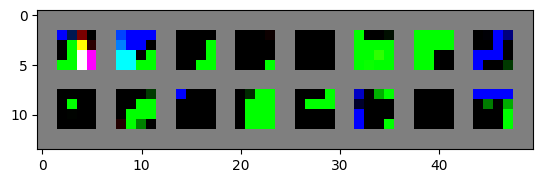

Training layer: 2
Alpha: 0
Alpha: 0.05


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Layer 2: Loss_D: 50.0, Loss_G: 100.0


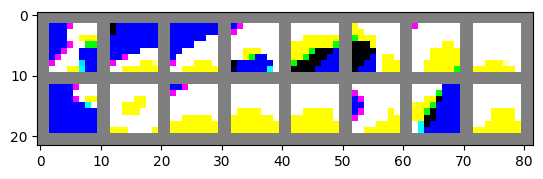

Training layer: 3
Alpha: 0
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromRGB: torch.Size([32, 256, 16, 16])
X after fromR

RuntimeError: Given groups=1, weight of size [256, 256, 3, 3], expected input[32, 512, 16, 16] to have 256 channels, but got 512 channels instead

In [59]:
# The paper has weight and bias init but I don't include it here, would need to think about how that will work

## We will train for 20*7 epochs
# Outer loop will handle the growing of layers
for layer in range(7):
    # This second loop will introduce alpha
    print(f'Training layer: {layer+1}')
    alpha = 0
    #for epoch_grow in range(20):
    for epoch_grow in range(2):
        print(f'Alpha: {alpha}')
        for i, data in enumerate(dataloader):
            real_images, _ = data
            real_images = real_images.to(device)

            noise_tensor = torch.randn((batch_size, 512, 1, 1), device=device)

            with torch.no_grad():
                # I keep getting an error here about final_g and noise_tensor not being in the same device
                # This is because when we init the new layers they are not on the device
                gen_images = final_g(noise_tensor, layer_num=layer+1, alpha=alpha)
            
            # Init the first G optim
            if optim_G is None:
                optim_G = torch.optim.Adam(final_g.parameters(), lr=0.001, betas=(0, 0.99), eps=10**(-8))
            
            # The real_images must be downsized to match the dims of the generated images
            real_images = F.interpolate(real_images, size=gen_images.shape[2:])
            
            gen_labels = torch.zeros((batch_size, 1)).to(device)
            real_labels = torch.ones((batch_size, 1)).to(device)

            # Concat fake and real images
            combined_images = torch.cat((real_images, gen_images))
            combined_labels = torch.cat((real_labels, gen_labels))

            # First update the D model
            final_d.zero_grad()
            d_outputs_combined = final_d(combined_images, layer_num=layer+1, alpha=alpha) 
            
            # Init the first D optim
            if optim_D is None:
                optim_D = torch.optim.Adam(final_d.parameters(), lr=0.001, betas=(0, 0.99), eps=10**(-8))
            
            loss_d = criterion(d_outputs_combined, combined_labels)
            loss_d.backward()
            optim_D.step()
            
            # Generate new images for updating G
            noise_tensor = torch.randn((batch_size, 512, 1, 1)).to(device)

            # Next update the G model, 
            final_g.zero_grad()
            gen_images = final_g(noise_tensor, layer_num=layer+1, alpha=alpha)  # Gen new images for training G
            # For generator updating we need the labels for generated images to be 1's to fool the discriminator
            # We do this by just passing the real_labels to the loss function
            # Note we use the D model, the equation in the paper is max log(D(G(z))) and we already have G(z)
            d_outputs_generated = final_d(gen_images)
            loss_g = criterion(d_outputs_generated, real_labels)
            loss_g.backward()
            optim_G.step()
            
            #break
        
        alpha += 1/20
        alpha = round(alpha, 2)
        #break
    # Set optimisers to None for reintialisation
    optim_D = None
    optim_G = None
    
    print(f'Layer {layer+1}: Loss_D: {loss_d.item()}, Loss_G: {loss_g.item()}')
    imshow(torchvision.utils.make_grid(gen_images.cpu()))
    
    #break


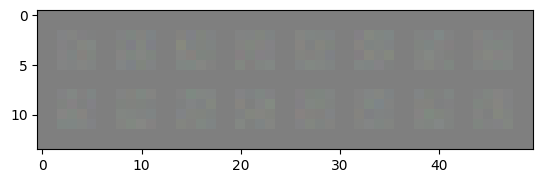

In [29]:
imshow(torchvision.utils.make_grid(gen_images.cpu()))